In [3]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.8 MB/s eta 0:00:0000:0100:01


In [5]:
import numpy as np
import pandas as pd

import json
import torch
from torch import nn
from tqdm import tqdm
import faiss
import sqlite3
from transformers import BertModel, BertTokenizer

import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

In [7]:
product_df = pd.read_csv('data/labeled_appliances.csv')
product_df.head()

,id,title,description,label
0,B07W42P978,WD12X10327 Rack Roller and stud assembly Kit (...,PARTS NUMBERThe WD12X10327 dishwasher top rack...,29
1,B083Q6Y54F,G.a HOMEFAVOR Cold Brew Coffee Infuser 64oz (2...,COMPLETE COLD BREW SYSTEM The Cold Brew Kit is...,19
2,B00KAS9ZMG,3-pack OnePurify Water Filter Replacement Cart...,This OnePurify refrigerator water filter conta...,0
3,B01AQHSNSM,SAMSUNG DA97-11092B Genuine OEM Ice Maker Asse...,This high quality Genuine OEM Samsung Ice Make...,32
4,B0BWCL9WCH,PARTY BARGAINS 600 Paper Coffee Filters - Whit...,PARTY BARGAINS Disposable Coffee Filters Sing...,7


In [9]:
file='data/meta_Appliances.jsonl'

products = []

with open(file, 'r') as fp:
    for line in fp:
        products.append(json.loads(line.strip()))

In [11]:
products[0]

{'main_category': 'Industrial & Scientific',
 'title': 'ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)',
 'average_rating': 3.7,
 'rating_number': 61,
 'features': ['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food',
  '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like',
  '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take 

In [13]:
extra_product_info = {product['parent_asin']: [product['average_rating'], product['rating_number'], product['images'][0]['thumb'] if (len(product['images']) > 0) and ('thumb' in product['images'][0]) else '', product['store']] for product in products}


In [15]:
extra_product_df = pd.DataFrame.from_dict(extra_product_info, orient="index")


In [17]:
extra_product_df.columns = ['average_rating', 'number_of_ratings', 'thumbnail_image_link', 'store']


In [19]:
extra_product_df.head()

,average_rating,number_of_ratings,thumbnail_image_link,store
B08Z743RRD,3.7,61,https://m.media-amazon.com/images/I/31idkuA3Kl...,ROVSUN
B097BQDGHJ,4.2,75,https://m.media-amazon.com/images/I/41tg+CPGV-...,HANSGO
B00IN9AGAE,3.5,18,https://m.media-amazon.com/images/I/21HQKcHPIk...,GE
B0C7K98JZS,4.5,26,https://m.media-amazon.com/images/I/31Huc5+m+T...,folosem
B07QZHQTVJ,3.8,12,https://m.media-amazon.com/images/I/31o9GyU6jn...,Whirlpool


In [21]:
product_df = product_df.set_index('id')

In [23]:
final_df = product_df.join(extra_product_df)

In [25]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B07W42P978,WD12X10327 Rack Roller and stud assembly Kit (...,PARTS NUMBERThe WD12X10327 dishwasher top rack...,29,4.6,323,https://m.media-amazon.com/images/I/31pHqGkkPf...,AMI PARTS
B083Q6Y54F,G.a HOMEFAVOR Cold Brew Coffee Infuser 64oz (2...,COMPLETE COLD BREW SYSTEM The Cold Brew Kit is...,19,4.5,326,https://m.media-amazon.com/images/I/41EPlLNVx6...,G.a HOMEFAVOR
B00KAS9ZMG,3-pack OnePurify Water Filter Replacement Cart...,This OnePurify refrigerator water filter conta...,0,4.3,236,https://m.media-amazon.com/images/I/51ziphmPX0...,OnePurify
B01AQHSNSM,SAMSUNG DA97-11092B Genuine OEM Ice Maker Asse...,This high quality Genuine OEM Samsung Ice Make...,32,4.6,579,https://m.media-amazon.com/images/I/412Tluo5WO...,SAMSUNG
B0BWCL9WCH,PARTY BARGAINS 600 Paper Coffee Filters - Whit...,PARTY BARGAINS Disposable Coffee Filters Sing...,7,4.5,8934,https://m.media-amazon.com/images/I/51U1jC9XdW...,PARTY BARGAINS


In [31]:
#final df
final_df.to_csv("data/final_appliances_df.csv", index=True)

In [35]:
# reading from saved df
final_df = pd.read_csv("data/final_appliances_df.csv", index_col='id')

In [37]:
final_df.head()

,title,description,label,average_rating,number_of_ratings,thumbnail_image_link,store
id,,,,,,,
B07W42P978,WD12X10327 Rack Roller and stud assembly Kit (...,PARTS NUMBERThe WD12X10327 dishwasher top rack...,29,4.6,323,https://m.media-amazon.com/images/I/31pHqGkkPf...,AMI PARTS
B083Q6Y54F,G.a HOMEFAVOR Cold Brew Coffee Infuser 64oz (2...,COMPLETE COLD BREW SYSTEM The Cold Brew Kit is...,19,4.5,326,https://m.media-amazon.com/images/I/41EPlLNVx6...,G.a HOMEFAVOR
B00KAS9ZMG,3-pack OnePurify Water Filter Replacement Cart...,This OnePurify refrigerator water filter conta...,0,4.3,236,https://m.media-amazon.com/images/I/51ziphmPX0...,OnePurify
B01AQHSNSM,SAMSUNG DA97-11092B Genuine OEM Ice Maker Asse...,This high quality Genuine OEM Samsung Ice Make...,32,4.6,579,https://m.media-amazon.com/images/I/412Tluo5WO...,SAMSUNG
B0BWCL9WCH,PARTY BARGAINS 600 Paper Coffee Filters - Whit...,PARTY BARGAINS Disposable Coffee Filters Sing...,7,4.5,8934,https://m.media-amazon.com/images/I/51U1jC9XdW...,PARTY BARGAINS


In [39]:
final_df = final_df.loc[final_df['label'] != -1]

In [41]:
class QueryEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use fewer transformer layers for queries since they're shorter
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=2,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use mean pooling instead of CLS token for queries
        # This helps capture information from all tokens in short queries
        mask_expanded = attention_mask.unsqueeze(-1).expand(x.size())
        sum_embeddings = torch.sum(x * mask_expanded, 1)
        sum_mask = torch.sum(mask_expanded, 1)
        mean_embeddings = sum_embeddings / sum_mask
        return self.projection(mean_embeddings)

In [43]:
class ProductEncoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, output_embed_dim):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embed_dim)
        # Use more transformer layers for product descriptions since they're longer
        self.encoder = torch.nn.TransformerEncoder(
            torch.nn.TransformerEncoderLayer(embed_dim, nhead=8, batch_first=True),
            num_layers=4,
            norm=torch.nn.LayerNorm([embed_dim]),
            enable_nested_tensor=False
        )
        self.projection = torch.nn.Linear(embed_dim, output_embed_dim)
        
    def forward(self, tokenizer_output):
        # Move inputs to the same device as the model
        input_ids = tokenizer_output['input_ids'].to(self.embedding_layer.weight.device)
        attention_mask = tokenizer_output['attention_mask'].to(self.embedding_layer.weight.device)
        
        x = self.embedding_layer(input_ids)
        x = self.encoder(x, src_key_padding_mask=attention_mask.logical_not())
        # Use CLS token for product descriptions
        cls_embed = x[:,0,:]
        return self.projection(cls_embed)

In [45]:
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

query_encoder = QueryEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
query_encoder.load_state_dict(torch.load("appliances_query_encoder_v3.pt"))

description_encoder = ProductEncoder(vocab_size=tokenizer.vocab_size, embed_dim=512, output_embed_dim=128)
description_encoder.load_state_dict(torch.load("appliances_description_encoder_v3.pt"))

/var/folders/1b/yssk88t91gqfxx2tk6mrdln40000gn/T/ipykernel_56476/3784929027.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  query_encoder.load_state_dict(torch.load("app

<All keys matched successfully>

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [49]:
product_descriptions = list(final_df['description'])
product_ids = list(final_df.index)
batch_size=128
description_encoder = description_encoder.to(device)

sample_tokens = tokenizer(
    product_descriptions[0:1], 
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512
)

with torch.no_grad():
    sample_embedding = description_encoder(sample_tokens)
embedding_dim = sample_embedding.shape[1]

# Create FAISS index based on requested type
index = faiss.IndexFlatIP(embedding_dim)

# Encode all products in batches and add to index
print("Encoding products and adding to index...")
batch_product_ids = []

# Create batches for product descriptions
batches = [product_descriptions[i:i + batch_size] for i in range(0, len(product_descriptions), batch_size)]
batch_ids = [product_ids[i:i + batch_size] for i in range(0, len(product_ids), batch_size)]

for batch_desc, batch_id in tqdm(zip(batches, batch_ids), total=len(batches), desc="Building index"):
    tokens = tokenizer(
        batch_desc, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=512
    )
    
    # Encode batch
    with torch.no_grad():
        embeddings = description_encoder(tokens)
        # Normalize embeddings for cosine similarity
        embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
    # Add to index
    index.add(embeddings.cpu().numpy())
    batch_product_ids.extend(batch_id)

print(f"Index built with {len(batch_product_ids)} products")

Encoding products and adding to index...


Building index: 100%|███████████████████████████| 52/52 [15:20<00:00, 17.70s/it]

Index built with 6598 products


In [51]:
faiss.write_index(index, "data/appliances_embeddings_v3.index")


In [53]:
conn = sqlite3.connect("appliances_embeddings.db")
cursor = conn.cursor()

In [55]:
# CREATE SQL TABLE
cursor.execute("DROP TABLE IF EXISTS products")

cursor.execute("""
    CREATE TABLE products (
        id TEXT PRIMARY KEY,
        product_name TEXT,
        seller TEXT,
        product_description TEXT,
        num_ratings INTEGER,
        avg_rating REAL,
        image_link TEXT
    )
    """)
conn.commit()

# POPULATE SQL TABLE WITH PRODUCT DATA
for row in final_df.itertuples(index=True, name=None):
    prod_id, prod_name, prod_desc, _, avg_rating, num_rating, image_url, store = row
    cursor.execute(
        """INSERT OR REPLACE INTO products
        (id, product_name, seller, product_description, num_ratings, avg_rating, image_link) VALUES (?, ?, ?, ?, ?, ?, ?)""",
        (prod_id, prod_name, store, prod_desc, num_rating, avg_rating, image_url)
    )
conn.commit()

In [57]:
res = cursor.execute("SELECT * FROM products LIMIT 1")
res.fetchall()

[('B07W42P978',
  'WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003',
  'AMI PARTS',
  'PARTS NUMBERThe WD12X10327 dishwasher top rack wheels and stud assembly Kit 4 pcs SCOPE OF APPLICATIONThe dishwasher works with most top name brandsIf you are not sure if part is correct ask us in Customer questions  answers section or visiting the AMI PARTS storefrontWere happy to help ensure you select the correct part for your Rack Roller and stud REPLACES PART1811003 AP4980629 WD12X0330 WD12X0356 WD12X0357 WD12X0383 WD12X0385 WD12X10327 WD12X330 WD12X356 WD12X357 WD12X383 WD12X385 FIXES SYMPTOMSDoor wont close  Not cleaning dishes properly  Noisy  Door latch failure QUALITY WARRANTYThe replacement part is made from durable high quality material and welltested by manufacturerFor any reason youre not satisfiedyou can ask for a replacement or full refund',
  323,
  4.6,
  'https://m.media-amazon.com/images/I/31pHqGkkPfL._AC_SR38,50_.jpg')]

In [59]:
def search(query, product_embeddings, k=10):
    query_tokens = tokenizer(
        query, 
        padding=True, 
        truncation=True, 
        return_tensors="pt", 
        max_length=32
    )
    
    with torch.no_grad():
        query_embedding = query_encoder(query_tokens)
        query_embedding = torch.nn.functional.normalize(query_embedding, p=2, dim=1)
    
    similarities, indices = product_embeddings.search(query_embedding.cpu().numpy(), k)
    
    similarities = similarities.reshape(-1)
    indices = indices.reshape(-1)
    top_product_ids = list(final_df.index[indices])
    
    placeholders = ', '.join(['?'] * len(top_product_ids))
    query = f"SELECT id, product_name, product_description, seller, image_link FROM products WHERE id IN ({placeholders})"
    res = cursor.execute(query, top_product_ids)
    query_results = res.fetchall()
    
    results = [{
        'product_id': query_result[0],
        'product_name': query_result[1],
        'product_description': query_result[2],
        'seller': query_result[3],
        'image_url': query_result[4],
        'similarity_score': similarity
    } for query_result, similarity in zip(query_results, similarities)]
    
    return results


In [61]:
index = faiss.read_index("data/appliances_embeddings_v3.index")

In [67]:
search_results = search("water filter for fridge", index)

Product Name: Electrolux EWF2CBPA Pure Advantage Water Filter, 1 Count (Pack of 1)
Product Description: Product Description Keep safe great tasting water flowing with Electrolux Icon Pure Advantage ice and water filter If you are sensing an odd scent or flavor in the water and ice that comes from your refrigerator it may be time to replace the filter This replacement fridge filter will help bring pure and delicious water that you can use for drinking and cooking From the Manufacturer The Electrolux ICON Pure Advantage IceWater Filter EWF2CBPA  NGFC 2000 fits refrigerators with a slideout filter ca


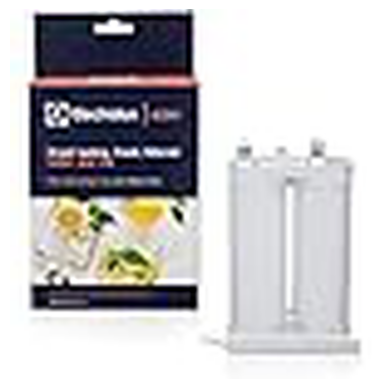

Product Name: Waterdrop MSWF Refrigerator Water Filter, Replacement for GE® MSWF, 101820A, 101821B, RWF1500A, Pack of 3
Product Description: This filter is replacement for MSWF not GSWF Replacement for filter models GE MSWF 101820A 101820A 101821B 101821B 238C2334P003 AP3997949 MSWF3PK MSWFDS PC46783 PS1559689 WR02X12345 WR02X12801 RWF1062 CF12 PF12 This filter is not sourced by or sponsored by GE WR17X11608 GE SIDEBYSIDE AND FRENCHDOOR REFRIGERATORS WR02X12345 WR02X12801 This Waterdrop refrigerator water filter replacement for GE MSWF despite its affordable price offers the best  a mix of prior filtration performance and important c


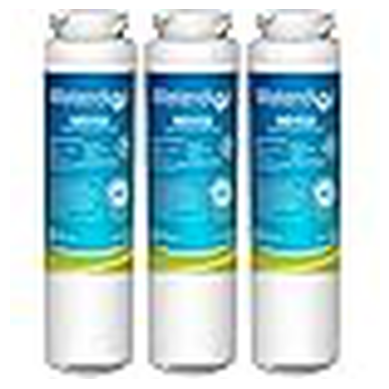

Product Name: Filterlogic UKF8001 Water Filter, Replacement for EveryDrop Filter 4, EDR4RXD1, Maytag UKF8001P, UKF8001AXX, Whirlpool 4396395, 469006, FMM-2, Puriclean II (Pack of 4)
Product Description: FilterLogic FLRF13 Replacement Refrigerator Water Filter Where Healthy Water Begins Filterlogic replacement refrigerator water filter is your most costeffective choice The exquisite design promises leakfree fit and it offers reasonable price without compromising quality Compatible Refrigerator Models BSS25JFRJWW DSS25KGREBB GCU23LGYDFSS GFSS2KEYCSS GFSS6KKYCSS GFSS6KKYESS GSC22KGRDWW GSF25IGXPBB GSH25JFXJWW GSH25JFXNWW GSHL5KGXCCLS GSHL5KGXGCLS GSHS6HGDBCSS GSL25IGXNLS GSL25QGPDBS GSS22QFMCCC GS


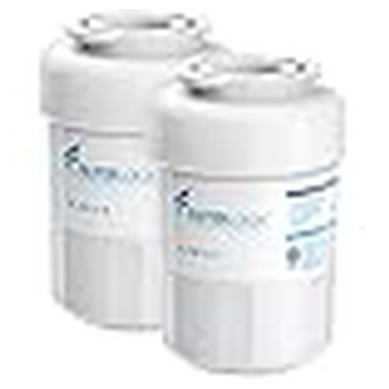

Product Name: Supplying Demand W10190965 W10190966 Refrigerator Ice Maker Assembly Replacement No Bail Arm Model Specific Not Universal
Product Description: Please see Model Number fitment information at the bottom of this page before placing your order for this part Alternate part numbers include WPW10190965 AP6016628 1471727 626633 626661 626662 PS11749920 W10122506 W10122507 W10122510 W10190969 W10270037 and WPW10190965VP 115V  185W  16A  60Hz  8 Cube heated mold with flat 4 pin plug  Ice maker only use hardware and bail arm from your old unit  Fits model specific sidebyside refrigerators It is important to disconnect your appliance from the powe


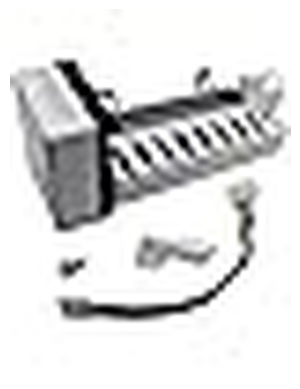

Product Name: WP2260518W 2260518W Water Filter Cap 2260502W Kenmore Refrigerator AP6006884 PS11739972 KSCS25INSS00 ED2FHEXSS00 ED2VHEXVQ01 ED5FHEXVS01 ED5VHEXVB04 106.57712703 MSF22C2EXW00 ASD2522WRW02 106.56834603
Product Description: Water Filter Cap Wp2260518w For Refrigerators  A highquality exact equivalent for part numbers 2260518W AP6006884 2260502W 1058149 PS11739972 WP2260518WVP Refrigerator Replacement Wp2260518w Filter Cap is compatible with Whirlpool Amana Inglis JennAir Kenmore KitchenAid Maytag appliances It is designed to fit over the water filter housing and keep the water filter in place It fits dozens of models and can be easily installed  DIY eTips Included  Not sure how to replace the part Helpful informati


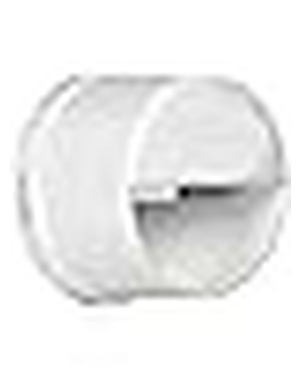

Product Name: Supplying Demand 8557884 W10874409 Clothes Dryer Lint Screen Filter Replacement Model Specific Not Universal
Product Description: Please see Model Number fitment information at the bottom of this page before placing your order for this part Alternate part numbers include AP602 8557861 8558467 8559786 W10726386 W10860233 WP8557861 WP8559786 341256 348855 348858 689469 689471 696021 696022 80007 DE524 K85956 PS11738127 TJ90DE524 and W10847983 Prevents lint buildup from blocking the exhaust and causing overheating  Fits model specific dryers The filter may be located on the top of your dryer or inside the dryer door depending


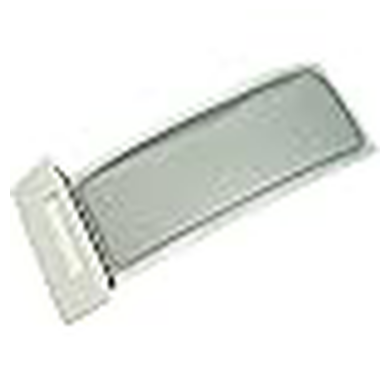

Product Name: DA29-00020B Refrigerator Water Filter, Compatible with Samsung Refrigerator Water Filter
Product Description: DA2900020B Refrigerator Water Filter compatible with Samsung 1 pack Refrigerator Water Filter When you buy a Samsung sidebyside or A French door refrigerator with ice and water dispenser rest assured that it comes with a water filtration systemThis true Samsung water filter provides clean clear water that looks and tastes great and protects your refrigerator components from potential sediment Follow the packaging instructions when installing this real Samsung filter Make Sure This Fits By Enteri


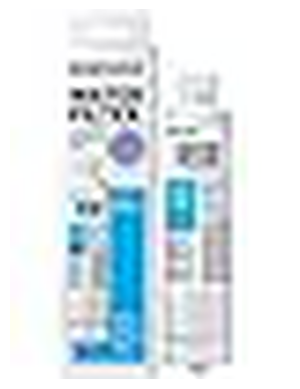

Product Name: Waterdrop MWF Water Filter for GE® Refrigerators, Replacement for GE® MWF, SmartWater® MWFP, MWFA, GWF, HDX FMG-1, WFC1201, RWF1060, 197D6321P006, Kenmore® 9991, GSE25GSHECSS, 3 Filters
Product Description: This Waterdrop WDF13 refrigerator water filter replacement for GE MWF despite its affordable price offers the best  a mix of prior filtration performance and important certifications from the wellknown regulatory body in the industry  NSF 42 and NSF 372 certificates GE is a registered trademark of General Electric Company GE is used for reference purposes only Replacement for filter models GE MWF Refrigerator Water Filter GE MWF Water Filter GE GWF Water Filter GE MWFP Water Filter GE MWFA Water


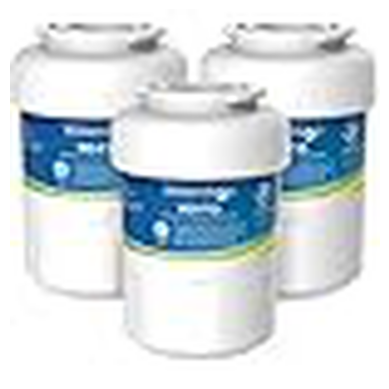

Product Name: Crystala LT1000PC Replacement Water Filter, Compatible with LT1000PC/PCS, LT1000PC, LT-1000PC, MDJ64844601, ADQ747935 ADQ74793504 Water Filter and LT120F ADQ73334008 Fresh Air Filter 3 Pack
Product Description: Crystala CF16 LT1000PC Water Filter Statement The materials and construction are in compliance with the NSF42 standard After our laboratory tested refrigerator water filter to remove 979 chlorine and improves waters smell and taste Find NSF 42 Standard information Go to NSFs database enter the certified model number CF16 or manufacturer Ningbo Pureza Technology LLC If you find that the product is not NSF42 certified you can claims identified in the NSF listing Water Filter LT1000p Compatible Mod


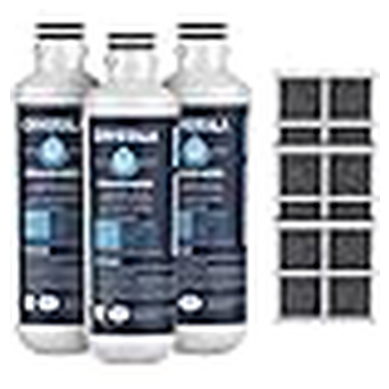

Product Name: Waterdrop MSWF Refrigerator Water Filter, Replacement for GE® MSWF, 101820A, 101821B, RWF1500A, Pack of 1
Product Description: Replacement for filter models GE MSWF 101820A 101820A 101821B 101821B 238C2334P003 AP3997949 MSWF3PK MSWFDS PC46783 PS1559689 WR02X12345 WR02X12801 RWF1062 CF12 PF12 This filter is not sourced by or sponsored by GE WR17X11608 GE SIDEBYSIDE AND FRENCHDOOR REFRIGERATORS WR02X12345 WR02X12801 This Waterdrop refrigerator water filter replacement for GE MSWF despite its affordable price offers the best  a mix of prior filtration performance and important certifications from the wellknown regulatory b


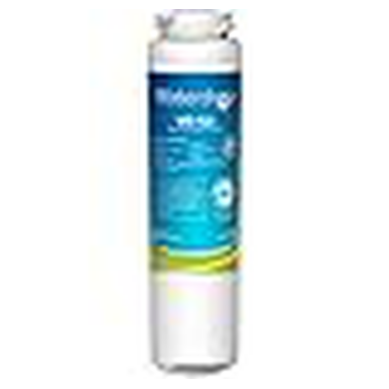

In [69]:
for result in search_results:
    try:
        # URL of the image
        image_url = result['image_url']
        
        # Fetch the image
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        
        target_size = (1000, 1000)
    
        # Calculate the aspect ratio
        img_ratio = img.width / img.height
        target_ratio = target_size[0] / target_size[1]
        
        if img_ratio > target_ratio:
            # Scale based on width
            new_width = target_size[0]
            new_height = int(new_width / img_ratio)
        else:
            # Scale based on height
            new_height = target_size[1]
            new_width = int(new_height * img_ratio)
        
        # Resize the image while maintaining the aspect ratio
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    
        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        # Display the resized image
        plt.imshow(img_resized)
        plt.axis('off')  # Hide the axes
        plt.show()
    except:
        print(f"Product Name: {result['product_name']}")
        print(f"Product Description: {result['product_description'][:500]}")
        print("No product image provided")